# Project Code Draft ##

## Import Statements ##

In [1]:
import scipy.io as sio
import inspect
import os
import contextlib
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
sns.set()

In [2]:
#SVM fails to converge using csp. This causes the printing of ~600 warnings. This limits that to 1 warning
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Data Pre-processing Functions ##

In [3]:
#function-type alias for use in type hints
function = type(lambda x: x)

######################## Data Dimensionality Reduction Methods ##############################################################
def sliding_window(X:np.ndarray, y:np.ndarray, window_length:int, step_size:int, step:int):
    w_start_idx = step_size*step
    w_end_idx = min( [X.shape[1]-1, w_start_idx + window_length] )
    if y is not None:
        return X[:, w_start_idx:w_end_idx, :], y[w_start_idx:w_end_idx]
    if y is None:
        return X[:, w_start_idx:w_end_idx, :]

#################### Laterized Readiness Potential Logic
def calc_lrp(X:np.ndarray): 
    X_reduced = X[23,:,:] - X[7,:,:]
    return X_reduced.T

def sliding_lrp(X:np.ndarray, y:np.ndarray, window_length:int, step_size:int, step:int):
    X_window, y_window = sliding_window(X, window_length, step_size, step)
    return calc_lrp(X_window), y_window

#################### Standard Scaler Logic

######################## MNE CSP transform logic

#Constants to save last-trained CSP objects
# and dictionary of saved CSP objects for later use
csp_transformer = mne.decoding.CSP()
csp_dict = {}

def csp_transform(X:np.ndarray, y:np.ndarray=None, n_components:int=None, transformer_label:str=None, only_train_on_new_label=False):
    global csp_transformer
    global csp_dict
    dim = X.shape
    X_shaped = X.reshape(dim[2], dim[0], dim[1])
    #if training data is given
    if y is not None:
        #if instructed to only train on new transformer label and transformer label is not new then exit function
        if only_train_on_new_label and transformer_label in csp_dict:
            return None
        #if n_components is specified, initialize CSP with those components, otherwise use default n_component values
        if n_components is not None:
            csp_transformer = mne.decoding.CSP(n_components)
        else:
            csp_transformer = mne.decoding.CSP()
        #Supress lengthy print statements from CSP and train
                    #WARNING: This will supress all warnings and errors. ONLY USE IF CODE HAS BEEN TESTED
                    # AND IT IS KNOWN THAT IT WILL NOT CRASH DURING THE FITTING PROCEDURE 
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            csp_transformer.fit(X_shaped, y)
        if transformer_label is not None:
            csp_dict[transformer_label] = csp_transformer
        return None        
    else:
        #Supress lengthy print statements from CSP and transform data
                    #WARNING: This will supress all warnings and errors. ONLY USE IF CODE HAS BEEN TESTED
                    # AND IT IS KNOWN THAT IT WILL NOT CRASH DURING THE FITTING PROCEDURE 
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            if transformer_label is not None:
                return csp_dict[transformer_label].transform(X_shaped)
            else:
                return csp_transformer.transform(X_shaped)

def sliding_csp_transform(X:np.ndarray,
                          window_length:int, 
                          step_size:int,
                          step:int,
                          y:np.ndarray=None,
                          n_components:int=None,
                          transformer_label:str=None,
                          refit_csp=False):
    X_window, y_window = sliding_window(X, window_length, step_size, step)
    if refit_csp:
        csp_transform(X_window, y_window, n_components, transformer_label)
    return csp_transform(X_window, transformer_label=transformer_label), y_window
    
def sliding_csp_fit_transform(X:np.ndarray,
                              window_length:int,
                              step_size:int,
                              step:int,
                              y:np.ndarray,
                              n_components:int=None,
                              transformer_label:str=None):
    X_window, y_window = sliding_window(X, window_length, step_size, step)
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_window, y_window, train_size=0.3)
    csp_transform(X_tr, y_tr, n_components, transfomer_label)
    return csp_transform(X_ts), y_ts, X_tr, y_tr
    
######################################### Data Formatting Logic ################################################
scaler = StandardScaler()
def Format(X:np.ndarray, 
           y:np.ndarray,  
           reduction_method:function, 
           reduction_method_args=None,
           trials_in_A:int=100
           normalize=False,
           fit_standard_scaler=False):
    if type(reduction_method_args) == dict:
        X_reduced = reduction_method(X, **reduction_method_args)
    elif type(reduction_method_args) == list:
        X_reduced = reduction_method(X, *reduction_method_args)
        
    else:
        X_reduced = reduction_method(X)
    if normalize:
        if fit_standard_scaler:
            scaler.fit(X_reduced)
        X_reduced = scaler.transform(X_reduced)
    condition_A_data_dict, condition_B_data_dict = condition_split(X_reduced, y, trials_in_A)
    return condition_A_data_dict, condition_B_data_dict

def condition_split(X:np.ndarray, y:np.ndarray, trials_in_A:int):
    AX, BX = X[:trials_in_A], X[trials_in_A:]
    Ay, By = y[:trials_in_A], y[trials_in_A:]
    A_dict = {'X': AX, 'y': Ay}
    B_dict = {'X': BX, 'y': By}
    return A_dict, B_dict


## Hyperparameter Tuning ##

#### Read in Hyperparameter Tuning Data ####

In [4]:
data = sio.loadmat('../Data/data_cube_subject1.mat')
channel_labels = sio.loadmat('../Data/channel_label.mat')
data_cube = data['data_cube']
data_labels = data['event_label'].ravel()

In [34]:
from sklearn.preprocessing import StandardScaler

_, B = Format(data_cube, data_labels, calc_lrp, None , 0)
B
scaler = StandardScaler()
print(scaler.fit(B['X']))
scaler.transform(B['X'])
#print(scaler.transform(B['X']))

StandardScaler()


array([[-2.20048635e-01,  1.34534596e-01,  1.62110354e-01, ...,
         1.06612506e+00,  7.13167296e-01,  6.95218438e-01],
       [-1.18878933e+00, -1.41716559e+00, -1.82139328e+00, ...,
         1.45487267e+00,  1.00050150e+00,  3.10685512e-01],
       [-3.64290164e-01, -1.03996690e-01, -2.28162575e-01, ...,
        -4.17795195e-03, -1.08265045e-01,  1.53123594e-01],
       ...,
       [ 8.99126610e-02,  1.79297155e-01,  2.28620853e-01, ...,
         5.93294407e-01,  9.59582033e-01,  6.94842602e-01],
       [-7.17150100e-01, -5.36444256e-01, -3.47359719e-01, ...,
         1.17531202e+00,  1.11450907e+01,  1.07289460e+01],
       [-6.66667177e-01, -6.61301641e-02, -8.48289991e-02, ...,
        -1.01330182e+00, -6.55143619e-01, -2.69760353e-01]])

In [5]:
#Divide data into CSP tuning and Hyperparameter Tuning Data
data_cube.shape
X_csp = data_cube[:,:,80:120]
y_csp = data_labels[80:120]
X_param_csp = np.vstack([data_cube[:,:,:80], data_cube[:,:,120:]])
y_param_csp = np.hstack([data_labels[:80],data_labels[120:]])

#fit CSP to proper data and save CSP object
csp_transform(X_csp, y_csp, transformer_label='hyperparam_tune')

#### Hyperparameter Tuning Constants ####

In [6]:
#Hyperparameter dictionaries for use in grid search
ada_params = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [x/20 for x in range(1,21)],
    'algorithm': ['SAMME', 'SAMME.R']
}

rf_params = {
    'n_estimators': [25, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': (None, 10, 50, 100),
    'min_samples_split': [2, 4, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ('auto', 'sqrt', 'log2', None),
    'min_impurity_decrease': (0.0, 0.5)
}

lda_params = {
    'solver': ['svd','lsqr','eigen'],
    'shrinkage': ['auto',None],
}

svm_params = {
    'C': np.logspace(-3,2,6),
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': [2,3,4],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3,3,6)),
    'shrinking': [True, False],
    'max_iter': [1000]
}

#Dictionary of classifiers and hyperparemeter selections
clfs = {
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LDA': LDA(),
    'SVM': SVC()
}

params = {
    'RandomForestClassifier': rf_params,
    'AdaBoostClassifier': ada_params,
    'LDA': lda_params,
    'SVM': svm_params
}

#data dimensionality reduction methods to opitmize for
    #note that csp transform will use n_components=4 for model hyperparameter tuning
    # n_components will be finalized in another round of cross-validation
    # runtime to validate all combinations of n_components and model hyperparameters too long
    # for our current computational capacity so this will have to do
reduction_methods = {
    'lrp': calc_lrp,
    'csp': lambda X: csp_transform(X, transformer_label='hyperparam_tune')
}

#### Hyperparameter Tuning Functions ####

In [7]:

def tune_multiple_models(data_matrix:np.ndarray, 
                         data_labels:np.ndarray, 
                         clf_list:list=None, 
                         reduction_method_list:list=None):
    if clf_list==None:
        clf_list = [key for key in clfs]
    if reduction_method_list==None:
        reduction_method_list = [key for key in reduction_methods]
    tuned_models = []
    for clf_ident in clf_list:
        for reduction_method_ident in reduction_method_list:
            tuned_models.append(tune_model(data_matrix, 
                                           data_labels, 
                                           clf_ident, 
                                           reduction_method_ident) )
    return tuned_models

def tune_model(data_matrix:np.ndarray, 
               data_labels:np.ndarray,
               clf_ident:str, 
               reduction_method_ident:str):
    #Let user know which model is being tuned
    print('Hyperparameter tuning', clf_ident, 'on data pre-processed by dimensionality reduction method {}.'.format(reduction_method_ident))
    #obtain classifier, hyperparameters from corresponding dictionaries
    clf = clfs[clf_ident]
    hyperparam_dict = params[clf_ident]
    reduction_method = reduction_methods[reduction_method_ident]
    #apply dimensionality reduction to data and split into different experiment classes
    #For model hyperparameter tuning, do not separate A and B conditions
    #TODO: When we have more data, it might be better to tune separate models for A and B classes
        #At the moment there is not enough data to tune each class independently
    _, data_dict = Format(data_matrix, data_labels, reduction_method, trials_in_A=0)
    #tune model
    X = data_dict['X']
    y = data_dict['y']
    clf_mod = GridSearchCV(clf, hyperparam_dict, n_jobs=7)
    start_time = timer()
    clf_mod.fit(X,y)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    return {
        'clf_type': clf_ident,
        'reduction_method': reduction_method_ident,
        'clf': clf_mod
    }




#### Tune n_components for CSP Data Reduction ###

In [8]:
n_component_candidates = [x for x in range(1,64)]
    
def tune_csp_args_cv(csp_models:list, 
                  n_component_list=list(range(1,64)), 
                  X:np.ndarray=data_cube, 
                  y:np.ndarray=data_labels,
                  n_folds=5,
                  memoize_csp_mod=True):
    #bring StandardScaler used for SVM into namespace
    global scaler
    #print CSP n_component tuning config. settings
    if memoize_csp_mod:
        print('CSP n_component tuning using memoization. First classifier will take longer to tune as memoization cache is filled.')
    #begin tuning
    for clf_dict in csp_models:
        #only tune models with hyperparameters optimized for CSP
        if clf_dict['reduction_method']!='csp':
            continue
        print('Tuning CSP n_components for {}'.format(clf_dict['clf_type']))
        start_time = timer()
        #ensure reduction_method_args entry is in clf_dict for saving tuned n_components
        if 'reduction_method_args' not in clf_dict:
            clf_dict['reduction_method_args'] = {}
        #initialize classification model to tune
        params = clf_dict['clf'].best_params_
        mod = clf_dict['clf'].estimator
        mod.set_params(**params)
        #Define best accuracy and best n_component variables to be optimized
        best_n = None
        best_acc = -1
        #iterate through all n_component options
        for n_components in n_component_list:
            acc_list = []
            cv = KFold(shuffle=True, n_splits=n_folds, random_state=1)
            #obtain n-fold cross validation scores for this n_component
            for train_idx, test_idx in cv.split(y):
                #create label unique to this training data and n_component number
                    # label will be used for memoizing fitted CSP object on this training data
                transform_lbl = '{data}~{n_comp}'.format(data=X[:,:,train_idx], n_comp=n_components)
                #fit csp transform
                 #Supress lengthy print statements from CSP
                    #WARNING: This will supress all warnings and errors. ONLY use if code has been
                    # tested and is known to not crash during the transform.
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                    csp_transform(X[:,:,train_idx], 
                                  y[train_idx], 
                                  n_components, 
                                  transform_lbl,
                                  memoize_csp_mod)
                #specify data normalization for SVM 
                normalize=False
                if clf_dict['clf_type'] == 'SVM':
                    normalize=True
                    scaler.fit(csp_transform(X[:,:,train_idx], transformer_label=transform_lbl))
                #Transform data
                #Supress lengthy print statements from CSP
                #WARNING: This will supress all warnings and errors ONLY use if code has been
                    # tested and is known to not crash during the transform.
                with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                    reduction_args = {'transformer_label': transform_lbl}
                    _, data_dict = Format(X, y, csp_transform, reduction_args, 0, normalize=normalize, False)
                X_formatted, y_formatted = data_dict['X'], data_dict['y']
                X_tr, y_tr = X_formatted[train_idx], y_formatted[train_idx]
                X_ts, y_ts = X_formatted[test_idx], y_formatted[test_idx]
                mod.fit(X_tr, y_tr)
                y_pred = mod.predict(X_ts)
                acc_list.append(accuracy_score(y_ts, y_pred))
            ave_acc = sum(acc_list)/len(acc_list)
            if ave_acc > best_acc:
                best_acc = ave_acc
                best_n = n_components
        stop_time = timer()
        print('\t Done. Best n_components: {comp}. Best accuracy {ac}. Wall time elapsed: {tm}'.format(comp=best_n, ac=best_acc, tm=timedelta(seconds=stop_time-start_time)))
        clf_dict['reduction_method_args']['n_components'] = best_n
    return csp_models
        

## Model Evaluation And Selection ##

## Model Evaluation Functions ##

In [9]:

def prepare_data(X_train:np.ndarray, 
                 X_test:np.ndarray, 
                 y_train:np.ndarray, 
                 reduction_method:function, 
                 reduction_method_args:dict):
    #determine if reduction method requires fitting on training data
    #the following method determines if reduction method requires data labels, if it does
    # this implies the reduction method has to be fit to the data
    if 'y' in list(inspect.signature(reduction_method).parameters):
        #fit reduction method to the data
        reduction_method(X_train, y=y_train, **reduction_method_args)
    #do dimensionality reduction on both training and testing data
    X_tr = reduction_method(X_train, **reduction_method_args)
    X_ts = reduction_method(X_test, **reduction_method_args)
    return X_tr, X_ts
    
def get_acc(clf_dict:dict, 
            X_tr:np.ndarray, 
            X_ts:np.ndarray,
            y_tr:np.ndarray,
            y_ts:np.ndarray,
            reduction_method:function,
            reduction_method_args:dict):
    data = (X_tr, X_ts, y_tr)
    X_tr, X_ts = prepare_data(*data, reduction_method, reduction_method_args)
    #assemble and train classifier
    params = clf_dict['clf'].best_params_
    mod = clf_dict['clf'].estimator
    mod.set_params(**params)
    mod.fit(X_tr, y_tr)
    #predict and obtain accuracy score
    y_pred = mod.predict(X_ts)
    return accuracy_score(y_ts, y_pred)


def evaluate_model_single_condition(clf_dict:dict, 
                                    X:np.ndarray, 
                                    y:np.ndarray, 
                                    reduction_method:function, 
                                    reduction_method_args:dict=None, 
                                    n_folds:int=5,
                                    n_iter:int=30):
    #array of trial accuracies
    acc_list_cv = []
    acc_list_dist = []
    #obtain reduction method arguments if not provided in parameters
    if reduction_method_args is None:
        if 'reduction_method_args' not in clf_dict:
            reduction_method_args = {}
        else:
            reduction_method_args = clf_dict['reduction_method_args']
    #perform k-fold cross-validation to estimate model accuracy
    cv = KFold(shuffle=True, n_splits=n_folds)
    print('Obtaining {folds}-fold CV accuracy for {model_lbl} using reduction method {reduct}.'.format(folds=n_folds,
                                                                                                       model_lbl=clf_dict['clf_type'], 
                                                                                                       reduct = clf_dict['reduction_method']))
    start_time = timer()
    for train_idx, test_idx in cv.split(y):
        #split data into train-test partitions
        X_tr, X_ts = X[:,:,train_idx], X[:,:,test_idx]
        y_tr, y_ts = y[train_idx], y[test_idx]
        acc = get_acc(clf_dict, X_tr, X_ts, y_tr, y_ts, reduction_method, reduction_method_args)
        acc_list_cv.append(acc)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    print('Obtaining {sample} sample distribution of accuracy scores for {model_lbl} using reduction method {reduct}.'.format(sample=n_iter, 
                                                                                                                              model_lbl=clf_dict['clf_type'], 
                                                                                                                              reduct = clf_dict['reduction_method']))
    start_time = timer()
    for i in range(n_iter):
        train_idx, test_idx = train_test_split(list(range(y.shape[0])))
        #split data into train-test partitions
        X_tr, X_ts = X[:,:,train_idx], X[:,:,test_idx]
        y_tr, y_ts = y[train_idx], y[test_idx]
        acc = get_acc(clf_dict, X_tr, X_ts, y_tr, y_ts, reduction_method, reduction_method_args)
        acc_list_dist.append(acc)
    stop_time = timer()
    print('\t Done. Wall time elapsed: {}'.format(timedelta(seconds=stop_time-start_time)))
    return np.array(acc_list_cv), np.array(acc_list_dist)

def evaluate_model_both_conditions(clf_dict:dict, 
                                   X:np.ndarray, 
                                   y:np.ndarray, 
                                   trials_in_A:int,
                                   reduction_method:function, 
                                   reduction_method_args:dict=None, 
                                   n_folds:int=5,
                                   n_iter=30):
    #collect parameters which do not vary between A and B conditions
    test_params = [reduction_method, reduction_method_args, n_folds]
    #obtain accuracy score on A and B separately
    A_acc_cv, A_acc_dist = evaluate_model_single_condition(clf_dict, X[:,:,:trials_in_A], y[:trials_in_A], *test_params)
    B_acc_cv, B_acc_dist = evaluate_model_single_condition(clf_dict, X[:,:,trials_in_A:], y[trials_in_A:], *test_params)
    return A_acc_cv, A_acc_dist, B_acc_cv, B_acc_dist

def evaluate_models(clfs:list, 
                    X:np.ndarray, 
                    y:np.ndarray, 
                    trials_in_A:int, 
                    reduction_methods:dict, 
                    reduction_method_arg_list:dict=None,
                    n_folds:int=5,
                    n_iter=30):
    #assemble test conditions, test conditions consist of a tuple (classifier_dict, reduction_method, reduction_method_args)
    if reduction_method_arg_list is None:
        reduction_method_arg_list = { method:None for method in reduction_methods }
    for clf in clfs:
        reduction_method = reduction_methods[clf['reduction_method']]
        reduction_method_args = reduction_method_arg_list[clf['reduction_method']]
        A_acc_cv, A_acc_dist, B_acc_cv, B_acc_dist = evaluate_model_both_conditions(clf, X, y, trials_in_A, reduction_method, reduction_method_args, n_folds)
        clf['A_accuracy_cv'] = A_acc_cv
        clf['A_accuracy_dist'] = A_acc_dist
        clf['B_accuracy_cv'] = B_acc_cv
        clf['B_accuracy_dist'] = B_acc_dist
    return clfs
                             
 

In [10]:
# with open('./bin/clfs.p','rb') as clf_pickle_file:
#     tuned_clfs = pickle.load(clf_pickle_file)

# tuned_models[1]['n_components'] = 6
# tuned_models[3]['n_components'] = 6

# dimensionality_reduction_methods = {'lsp': calc_lrp, 'csp': csp_transform}
# evaluate_models(tuned_models, data_cube, data_labels, 100, dimensionality_reduction_methods)

In [11]:
# tuned_models[0]['clf'].best_params_

## End Function Definitions. Begin Model Analysis ##
### Tune Hyperparameters ###

In [12]:
%%time
# #Tune hyperparameters.This block takes approximately 2 hours to complete on 7 cores
tuned_clfs = tune_multiple_models(data_cube, data_labels)
with open('./bin/clfs.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs, clf_pickle_file)

Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 1:18:25.898258
Hyperparameter tuning RandomForestClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:05:12.950763
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:32:37.856988
Hyperparameter tuning AdaBoostClassifier on data pre-processed by dimensionality reduction method csp.
	 Done. Wall time elapsed: 0:00:45.763625
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method lrp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [  nan 0.715 0.715 0.69  0.57    nan]
  warnings.warn(


	 Done. Wall time elapsed: 0:01:45.629543
Hyperparameter tuning LDA on data pre-processed by dimensionality reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [  nan 0.52  0.52  0.515 0.515 0.515]
  warnings.warn(


	 Done. Wall time elapsed: 0:00:00.071212
Hyperparameter tuning SVM on data pre-processed by dimensionality reduction method lrp.
	 Done. Wall time elapsed: 0:01:46.501958
Hyperparameter tuning SVM on data pre-processed by dimensionality reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


	 Done. Wall time elapsed: 0:00:03.642234
CPU times: user 1min 43s, sys: 14.4 s, total: 1min 58s
Wall time: 2h 40s


### Tune n_components for CSP dimensionality reduction ###

In [13]:
%%time
#This block runs in 2 hours on 3 cores
tune_csp_args_cv(tuned_clfs, n_component_list=list(range(1,64)))
with open('./bin/clfs.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs, clf_pickle_file)

CSP n_component tuning using memoization. First classifier will take longer to tune as memoization cache is filled.
Tuning CSP n_components for RandomForestClassifier
	 Done. Best n_components: 60. Best accuracy 0.52. Wall time elapsed: 0:28:21.422490
Tuning CSP n_components for AdaBoostClassifier
	 Done. Best n_components: 22. Best accuracy 0.53. Wall time elapsed: 0:06:17.772349
Tuning CSP n_components for LDA
	 Done. Best n_components: 18. Best accuracy 0.475. Wall time elapsed: 0:05:31.531224
Tuning CSP n_components for SVM


/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

	 Done. Best n_components: 11. Best accuracy 0.575. Wall time elapsed: 0:05:32.573192
CPU times: user 2h 17min 3s, sys: 1h 36min 18s, total: 3h 53min 22s
Wall time: 45min 43s


### Evaluate All Models and Select Best Model ###

In [14]:
%%time
dimensionality_reduction_methods = {'lrp': calc_lrp, 'csp': csp_transform}
evaluate_models(tuned_clfs, data_cube, data_labels, 100, dimensionality_reduction_methods, n_iter=200)
with open('./bin/clfs.p','wb') as clf_pickle_file:
    pickle.dump(tuned_clfs, clf_pickle_file)

Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:00.511660
Obtaining 30 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:02.923232
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:00.502916
Obtaining 30 sample distribution of accuracy scores for RandomForestClassifier using reduction method lrp.
	 Done. Wall time elapsed: 0:00:02.937146
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:14.122289
Obtaining 30 sample distribution of accuracy scores for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:01:24.763226
Obtaining 5-fold CV accuracy for RandomForestClassifier using reduction method csp.
	 Done. Wall time elapsed: 0:00:15.167835
Obtaining 30 sample distribution of accuracy scor

/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

	 Done. Wall time elapsed: 0:00:13.096475
Obtaining 30 sample distribution of accuracy scores for SVM using reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

	 Done. Wall time elapsed: 0:01:15.594743
Obtaining 5-fold CV accuracy for SVM using reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

	 Done. Wall time elapsed: 0:00:13.249092
Obtaining 30 sample distribution of accuracy scores for SVM using reduction method csp.


/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/dominic/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScale

	 Done. Wall time elapsed: 0:01:15.904252
CPU times: user 1h 58min 8s, sys: 51min 30s, total: 2h 49min 39s
Wall time: 23min 48s


#### Plot Model Perfomrance ###


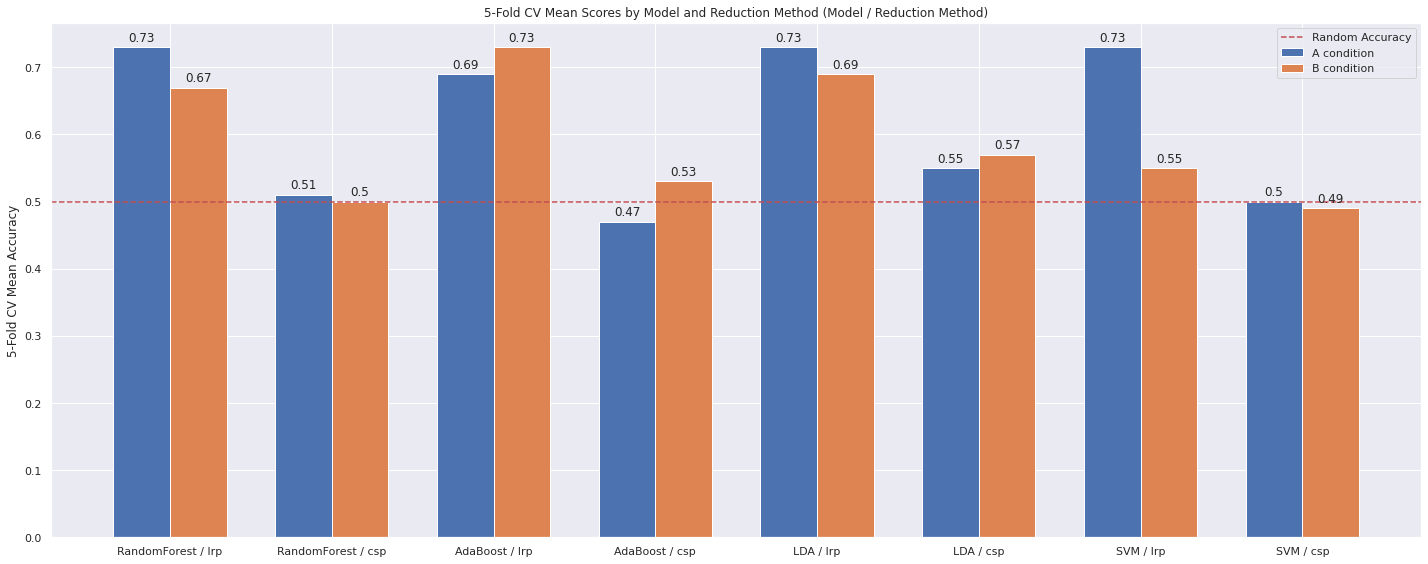

In [15]:
labels = []
A_acc = []
B_acc = []
for clf in tuned_clfs:
    mod_lbl = clf['clf_type']
    mod_reduct = clf['reduction_method']
    if mod_lbl=='RandomForestClassifier':
        mod_lbl = 'RandomForest'
    if mod_lbl=='AdaBoostClassifier':
        mod_lbl="AdaBoost"
    labels.append('{mod} / {reduct}'.format(mod=mod_lbl, reduct=mod_reduct))
    A_acc.append(clf['A_accuracy_cv'].mean())
    B_acc.append(clf['B_accuracy_cv'].mean())
    
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(20,8))

rects1 = ax.bar(x - width/2, A_acc, width, label='A condition')
rects2 = ax.bar(x + width/2, B_acc, width, label='B condition')
ax.axhline(y=0.5, color='r', linestyle='--', label='Random Accuracy')
ax.set_ylabel('5-Fold CV Mean Accuracy')
ax.set_title('5-Fold CV Mean Scores by Model and Reduction Method (Model / Reduction Method)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

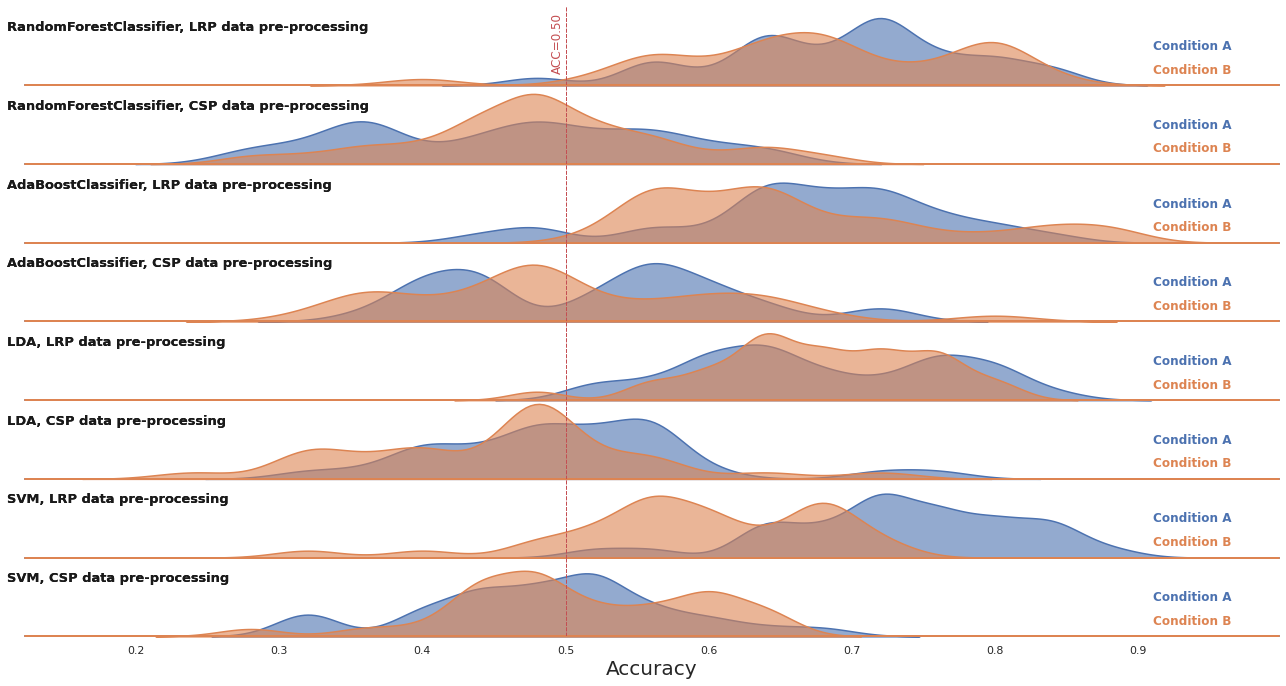

In [22]:
#assemble dataframe for use in plotting

acc_df = pd.DataFrame(columns = ['acc','test_cond','clf_type'])

for clf in tuned_clfs:
    clf_type = '{mod}, {reduct} data pre-processing'.format(mod=clf['clf_type'],
                                                                reduct=clf['reduction_method'].upper())
    data_preprocessing_method = clf['reduction_method']
    #add A condition accuracies
    test_cond = 'Condition A'
    for acc in clf['A_accuracy_dist']:
        row = {'acc': acc, 
               'test_cond': test_cond, 
               'clf_type': clf_type}
        acc_df = acc_df.append(row, ignore_index=True)
    #add B condition accuracies
    test_cond = 'Condition B'
    for acc in clf['B_accuracy_dist']:
        row = {'acc': acc, 
               'test_cond': test_cond, 
               'clf_type': clf_type}
        acc_df = acc_df.append(row, ignore_index=True)

#plot
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(acc_df, row='clf_type', hue='test_cond', aspect=15, height=1.2)
g.map(sns.kdeplot, 'acc', bw_adjust=.5, clip_on=False, fill=True, alpha=0.6, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

#plot control accuracy and label
g.map(plt.axvline, x=0.5, lw=1, color='r', linestyle='--')
plt.text(0.49,46.5,s='ACC=0.50', color='r',rotation=90)

#create function to draw plot labels
def label(x, color, label):
    ax = plt.gca()
    if label=='Condition A':
        ax.text(.9, .5, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    else:
        ax.text(.9, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)
    title = ax.get_title().replace('clf_type = ', '')
    ax.text(.11,4.5, title, fontweight='bold', color='k', fontsize=13)

#draw labels
g.map(label, 'acc')
#allow plot elements to overlap ax boundaries
g.fig.subplots_adjust(hspace=-0)
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.xlabel('Accuracy', fontsize=20)
warnings.filterwarnings('ignore')


#plot

plt.show()
#warnings.filterwarnings('once')